In [4]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
ses = SparkSession.builder.master("local[4]").appName("tuan").getOrCreate()
sc = ses.sparkContext

ratingsFile = sc.textFile("ratings.csv")
header = ratingsFile.first()
ratingsRDD = ratingsFile.filter(lambda x: x != header).map(lambda x: x.split(","))

In [2]:

movieRDD = ratingsRDD.map(lambda x: (x.split(",")[1], x.split(",")[2]))
mappedRDD = movieRDD.map(lambda x: (x,1))
targetRDD = mappedRDD.reduceByKey(lambda x,y: x + y)

In [5]:
import pandas
ratingsDF = ses.read.csv("ratings.csv", header=True, inferSchema=True)
ratingsDF.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
|     1|    163|   5.0|964983650|
|     1|    216|   5.0|964981208|
|     1|    223|   3.0|964980985|
|     1|    231|   5.0|964981179|
|     1|    235|   4.0|964980908|
|     1|    260|   5.0|964981680|
|     1|    296|   3.0|964982967|
|     1|    316|   3.0|964982310|
|     1|    333|   5.0|964981179|
|     1|    349|   4.0|964982563|
+------+-------+------+---------+
only showing top 20 rows



In [6]:
ratingsCountDF = ratingsDF.groupBy('movieId').count()
filteredDF = ratingsCountDF.filter(col('count') >= 20)
filteredDF.show()

+-------+-----+
|movieId|count|
+-------+-----+
|   1580|  165|
|   2366|   25|
|   3175|   75|
|   1088|   42|
|  44022|   23|
|   1591|   26|
|   1645|   51|
|    471|   40|
|   1025|   25|
|   1127|   62|
|   2580|   39|
|   1084|   35|
|   1721|  140|
|    858|  192|
|  48780|   90|
|   3698|   34|
|   4161|   23|
|   6773|   22|
|    737|   20|
|  69481|   34|
+-------+-----+
only showing top 20 rows



In [134]:
partRatingsDF = ratingsDF.select(col('movieId'), col('rating'))
targetDF = partRatingsDF.join(filteredDF, 'movieId')


In [135]:
avgDF = targetDF.groupBy(col('movieId')).agg(avg(col('rating')).alias('average_rating'))
avgDF.sort(col('movieId').asc()).show()

+-------+------------------+
|movieId|    average_rating|
+-------+------------------+
|      1|3.9209302325581397|
|      2|3.4318181818181817|
|      3|3.2596153846153846|
|      5|3.0714285714285716|
|      6| 3.946078431372549|
|      7| 3.185185185185185|
|     10| 3.496212121212121|
|     11|3.6714285714285713|
|     16| 3.926829268292683|
|     17|3.7761194029850746|
|     18|               3.7|
|     19| 2.727272727272727|
|     21|  3.49438202247191|
|     22|3.2222222222222223|
|     24|             3.125|
|     25|             3.625|
|     29|4.0131578947368425|
|     31|3.1842105263157894|
|     32| 3.983050847457627|
|     34|        3.65234375|
+-------+------------------+
only showing top 20 rows



In [17]:
avgPandas = avgDF.toPandas()

In [20]:
avgPandas

,movieId,average_rating
0,1580,3.487879
1,2366,3.640000
2,3175,3.580000
3,1088,3.369048
4,44022,3.217391
...,...,...
1292,3825,2.741379
1293,2376,3.214286
1294,48385,3.346154
1295,1476,3.538462


<AxesSubplot: title={'center': 'Average Ratings per Movie'}, xlabel='movieId'>

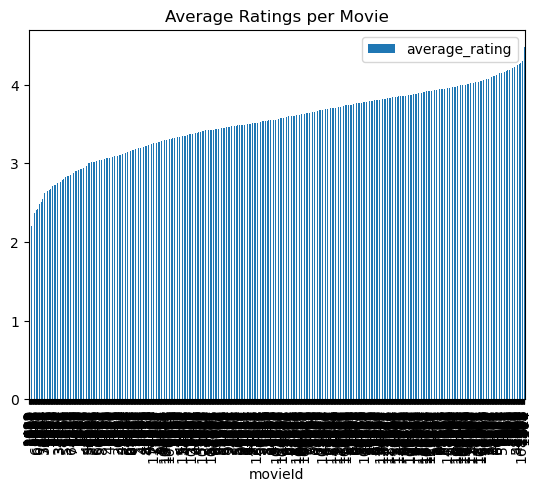

In [23]:
avgPandas.sort_values('average_rating').plot(x='movieId', y='average_rating', kind='bar', title='Average Ratings per Movie')

In [8]:
moviesFile = sc.textFile("movies.csv")
header = moviesFile.first()
moviesRDD = moviesFile.filter(lambda x: x != header).map(lambda x: x.split(","))


In [206]:
mappedMovies = moviesRDD.map(lambda x: (x[0], x[1]))

In [10]:
ratingsDF = ses.read.csv("ratings.csv", header=True, inferSchema=True)
moviesDF = ses.read.csv('movies.csv', header=True, inferSchema=True)
moviesDF.show(truncate=False)

ratingsCountDF = ratingsDF.groupBy('movieId').count()
ratingsCountDF.show(truncate=False)

+-------+-------------------------------------+-------------------------------------------+
|movieId|title                                |genres                                     |
+-------+-------------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                     |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                       |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)              |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)             |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)   |Comedy                                     |
|6      |Heat (1995)                          |Action|Crime|Thriller                      |
|7      |Sabrina (1995)                       |Comedy|Romance                             |
|8      |Tom and Huck (1995)                  |Adventure|Children               

In [11]:
joinedDF = moviesDF.join(ratingsCountDF, "movieId")
joinedDF.select(col('movieId'), col('title'), col('count')).orderBy(col('movieId')).show(truncate=False)
joinedDF.select('movieId', 'title', 'count').where(col('movieId') == 6).show(truncate=False)
joinedDF.select('movieId', 'title', 'count').where(col('title') == 'Usual Suspects, The (1995)').show(truncate=False)

+-------+-------------------------------------+-----+
|movieId|title                                |count|
+-------+-------------------------------------+-----+
|1      |Toy Story (1995)                     |215  |
|2      |Jumanji (1995)                       |110  |
|3      |Grumpier Old Men (1995)              |52   |
|4      |Waiting to Exhale (1995)             |7    |
|5      |Father of the Bride Part II (1995)   |49   |
|6      |Heat (1995)                          |102  |
|7      |Sabrina (1995)                       |54   |
|8      |Tom and Huck (1995)                  |8    |
|9      |Sudden Death (1995)                  |16   |
|10     |GoldenEye (1995)                     |132  |
|11     |American President, The (1995)       |70   |
|12     |Dracula: Dead and Loving It (1995)   |19   |
|13     |Balto (1995)                         |8    |
|14     |Nixon (1995)                         |18   |
|15     |Cutthroat Island (1995)              |13   |
|16     |Casino (1995)      

In [129]:
moviesRDD.collect()
mappedMoviesRDD = moviesRDD.map(lambda x: (x[0][0],x))
mappedMoviesRDD.join(answerRatingsRDD)
# responseRDD = moviesRDD.join(answerRatingsRDD)
# responseRDD.collect()

PythonRDD[711] at RDD at PythonRDD.scala:53

In [121]:
mappedPandas

,movieId,average_rating
0,1580,3.487879
1,2366,3.640000
2,3175,3.580000
3,1088,3.369048
4,32460,4.250000
...,...,...
9719,5836,2.000000
9720,6477,3.000000
9721,73501,3.500000
9722,2965,2.000000
